In [1]:
import torch
import torchvision
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, random_split
import numpy as np
import matplotlib.pyplot as plt

In [2]:
print(torch.cuda.is_available())

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

True


In [3]:
preprocessor_aug = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

preprocessor_original = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_set = torchvision.datasets.CIFAR10(root="../Data/CIFAR10/", train=True, download=True, transform=preprocessor_original)
val_test_set = torchvision.datasets.CIFAR10(root="../Data/CIFAR10/", train=False, download=True, transform=preprocessor_original)
val_set, test_set = random_split(val_test_set, [5000, 5000])

train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=1, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=1, pin_memory=True)

class_labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


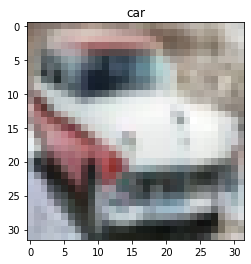

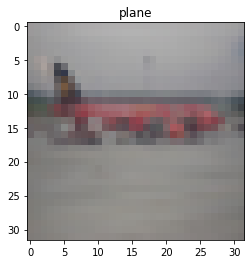

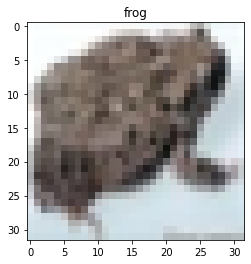

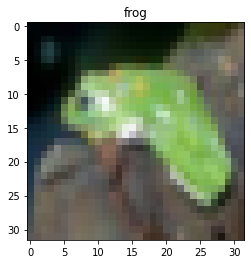

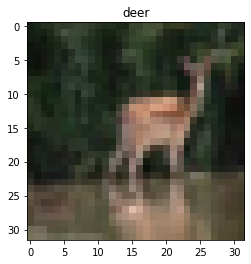

In [4]:
def show_image(img, label):
    plt.title(label)
    plt.imshow(img)
    plt.pause(0.01)

train_iter = iter(train_loader)
xb, yb = next(train_iter)

for i in range(5):
    show_image(np.transpose((xb[i]/2 + 0.5).numpy(), (1, 2, 0)), class_labels[yb[i]])

Some reasons it might be more difficult:
    - Colors, we have more dimensions now and that might affect the outcome.
    - More detail in the picture. In MNIST you could clearly see what it was meant to represent, here it is
    not as clear, as one can see above.
    - The background in MNIST is black while here you have details that might affect the performance,
    maybe even positively since a deer won't have a blue background like a plane. This might lead to the classifier
    recognising the wrong object, the enviroment around rather than the actual object.
    

In [5]:
model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 6, 5, 1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(6, 16, 5, 1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(),
    torch.nn.Linear(400, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10)
)

In [6]:

def loss_batch(model, loss_func, xb, yb, opt=None):
    out = model(xb)
    loss = loss_func(out, yb)
    preds = torch.argmax(out, dim=1)
    if opt is not None:
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item(), len(xb), (preds == yb).float().mean()

def fit(epochs, model, loss_func, opt, train_dl, valid_dl, test_dl):
    accuracy_plot = []
    loss_plot = []
    train_accuracy_plot = []
    train_loss_plot = []
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        print('-'*10)
        losses = np.array([])
        nums = np.array([])
        accuracies = []
        model.train()
        for xb, yb in train_dl:
            xb = xb.to(dev)
            yb = yb.to(dev)
            loss, num, acc = loss_batch(model, loss_func, xb, yb, opt)
            np.append(losses, loss)
            np.append(nums, num)
            accuracies.append(acc)

        print("Train accuracy: " + str((np.sum(accuracies)/len(accuracies)).item()))
        epoch_train_acc = np.sum(accuracies)/len(accuracies)
        epoch_train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        train_accuracy_plot.append(epoch_train_acc)
        train_loss_plot.append(epoch_train_loss)

        model.eval()
        with torch.no_grad():
            losses, nums, accuracy = zip(*[loss_batch(model, loss_func, xb.to(dev), yb.to(dev)) for xb, yb in valid_dl])

        val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
        accuracy = np.sum(accuracy)/len(accuracy)
        print("Accuracy: " + str(accuracy.item()))
        accuracy_plot.append(accuracy)
        loss_plot.append(val_loss)
        print('Epoch: ' + str(epoch+1) + ' loss: ' + str(val_loss) + '\n')

    model.eval()
    with torch.no_grad():
        losses, nums, accuracy = zip(*[loss_batch(model, loss_func, xb.to(dev), yb.to(dev)) for xb, yb in test_dl])

    val_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)
    accuracy = np.sum(accuracy)/len(accuracy)
    print("Test accuracy: " + str(accuracy.item()))
    print('Test loss: ' + str(val_loss) + '\n')
    return accuracy_plot, loss_plot, train_accuracy_plot, train_loss_plot

def test_single_batch(epochs, model, loss_func, opt, xb, yb):
    #Used to test if model is able to overfit a single batch, to see if the model is working.
    for epoch in range(epochs):
        if (epoch+1) % 100 == 0:
            print(f"Epoch {epoch+1}/{epochs}")
        model.train()

        xb = xb.to(dev)
        yb = yb.to(dev)
        loss_batch(model, loss_func, xb, yb, opt)

        if (epoch+1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                losses, nums, accuracy  = loss_batch(model, loss_func, xb, yb)
                print("Accuracy: " + str(accuracy.item()) + ' loss: '
                      + str(np.sum(np.multiply(losses, nums)) / np.sum(nums)) + '\n')


In [7]:
opti = [torch.optim.Adam(model.parameters(), lr=0.001), torch.optim.SGD(model.parameters(), lr=0.1)]
loss_func = torch.nn.CrossEntropyLoss()

model.to(dev)
# test_single_batch(1000, model, loss_func, opti[0], xb, yb)

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): ReLU()
  (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=400, out_features=120, bias=True)
  (8): ReLU()
  (9): Linear(in_features=120, out_features=84, bias=True)
  (10): ReLU()
  (11): Linear(in_features=84, out_features=10, bias=True)
)

Epoch 1/50
----------
Train accuracy: 0.4116082787513733
Accuracy: 0.49109968543052673
Epoch: 1 loss: 1.4065121900558473

Epoch 2/50
----------
Train accuracy: 0.5252519249916077
Accuracy: 0.5417326092720032
Epoch: 2 loss: 1.2842243984222412

Epoch 3/50
----------
Train accuracy: 0.570437490940094
Accuracy: 0.5686313509941101
Epoch: 3 loss: 1.2359718894958496

Epoch 4/50
----------
Train accuracy: 0.6006478071212769
Accuracy: 0.5886076092720032
Epoch: 4 loss: 1.1694662496566772

Epoch 5/50
----------
Train accuracy: 0.6248600482940674
Accuracy: 0.5990902185440063
Epoch: 5 loss: 1.1481198875427245

Epoch 6/50
----------
Train accuracy: 0.6430142521858215
Accuracy: 0.6064082384109497
Epoch: 6 loss: 1.122161144065857

Epoch 7/50
----------
Train accuracy: 0.6592090725898743
Accuracy: 0.6129351258277893
Epoch: 7 loss: 1.1228773094177247

Epoch 8/50
----------
Train accuracy: 0.6707453727722168
Accuracy: 0.6113528609275818
Epoch: 8 loss: 1.1173965394973755

Epoch 9/50
----------
Train accur

<ipython-input-6-055646feafff>:33: RuntimeWarning: invalid value encountered in double_scalars
  epoch_train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)


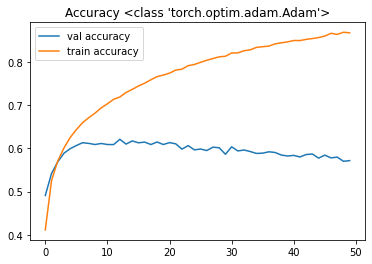

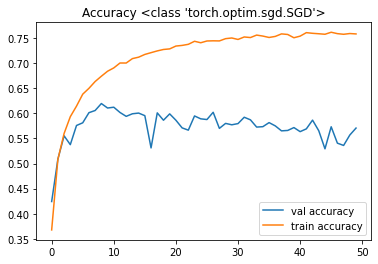

In [8]:
for opt in opti:
    a, b, c, d = fit(50, model, loss_func, opt, train_loader, val_loader, test_loader)
    plt.plot(a, label="val accuracy")
    plt.plot(c, label="train accuracy")
    plt.legend()
    plt.title("Accuracy " + str(type(opt)))
    plt.show()
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

In [9]:
train_set = torchvision.datasets.CIFAR10(root="../Data/CIFAR10/", train=True, download=True, transform=preprocessor_aug)
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=1, pin_memory=True)


model = torch.nn.Sequential(
    torch.nn.Conv2d(3, 6, 5, 1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Conv2d(6, 16, 5, 1),
    torch.nn.ReLU(),
    torch.nn.MaxPool2d(2, 2),
    torch.nn.Flatten(),
    torch.nn.Linear(400, 120),
    torch.nn.ReLU(),
    torch.nn.Linear(120, 84),
    torch.nn.ReLU(),
    torch.nn.Linear(84, 10)
)
opti = [torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01),
       torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.001)]

Files already downloaded and verified


Epoch 1/50
----------
Train accuracy: 0.5545225739479065
Accuracy: 0.5822784900665283
Epoch: 1 loss: 1.1812539167404175

Epoch 2/50
----------
Train accuracy: 0.5565618872642517
Accuracy: 0.5826740860939026
Epoch: 2 loss: 1.1882311159133911

Epoch 3/50
----------
Train accuracy: 0.5566219091415405
Accuracy: 0.5834652185440063
Epoch: 3 loss: 1.1862732528686524

Epoch 4/50
----------
Train accuracy: 0.5545825362205505
Accuracy: 0.6038370132446289
Epoch: 4 loss: 1.15800329246521

Epoch 5/50
----------
Train accuracy: 0.5553023219108582
Accuracy: 0.5866297483444214
Epoch: 5 loss: 1.1668189924240113

Epoch 6/50
----------
Train accuracy: 0.5557821393013
Accuracy: 0.5892009735107422
Epoch: 6 loss: 1.1995904481887818

Epoch 7/50
----------
Train accuracy: 0.5568618178367615
Accuracy: 0.5872231125831604
Epoch: 7 loss: 1.1714821559906006

Epoch 8/50
----------
Train accuracy: 0.5559220910072327
Accuracy: 0.594343364238739
Epoch: 8 loss: 1.1697146848678588

Epoch 9/50
----------
Train accuracy: 

<ipython-input-6-055646feafff>:33: RuntimeWarning: invalid value encountered in double_scalars
  epoch_train_loss = np.sum(np.multiply(losses, nums)) / np.sum(nums)


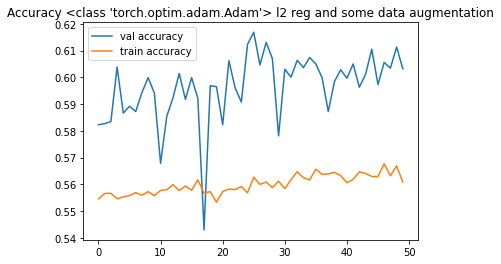

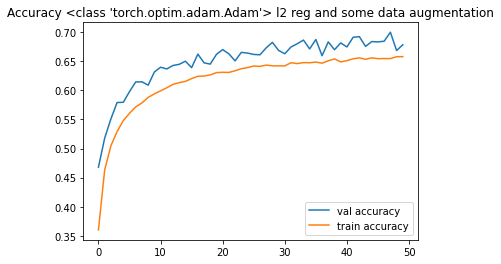

In [11]:
model.to(dev)
for opt in opti:
    a, b, c, d = fit(50, model, loss_func, opt, train_loader, val_loader, test_loader)
    plt.plot(a, label="val accuracy")
    plt.plot(c, label="train accuracy")
    plt.legend()
    plt.title("Accuracy " + str(type(opt)) + " l2 reg and some data augmentation")
    plt.show()
    for layer in model.children():
        if hasattr(layer, 'reset_parameters'):
            layer.reset_parameters()

The second run with lambda = 0.001 is performing about 10% better, I think a even lower lambda might be even better.
What is the reason that validation and test accuracy is better than train?

